In [18]:
using LaTeXStrings
using StatsPlots
pyplot()
using StatsBase
using Corpuscles
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using LinearAlgebra
#gr()
#theme(:gruvbox_dark)

In [19]:
#using Pkg; Pkg.build("FastJet")
#using Pkg; Pkg.build("LCIO")

Set A: 
Processes: Pmumuh2bb, Pmumuh2cc, Pmumuh2gg
"0_DST" > ".*_DST"

In [20]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

#can use a sort function where the key to sort on is dot(p, p)

leadingParticleIndex (generic function with 1 method)

In [21]:
#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

Strange Events

In [22]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\.0_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_ss[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [23]:
ss_MCleadPDG = []
ss_MCleadingParticlePList = []
ss_PFOleadPDG = []
ss_PFOleadingParticlePList = []
ss_kShortInPiPiEventList_MC = []
ss_kShortInPiPiEventList_PFO = []
ss_lambdaInProtonEventList_MC = []
ss_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_ss
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(ss_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(ss_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(ss_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            #大家好，如果你会读懂，我想告诉你很重要的事：加油！
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(ss_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(ss_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(ss_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

Produce figure with MC Particle and Pandora PFO breakdown for all 4 event types\
-Remove muon from everything\
-2 jets\
-Check if theres a K short in the pi pi highest particle events\
-If proton, check if lambda 0\
-just make a dictionary where name maps to value\
Run Z reco over MCParticle & PandoraPFO, compare

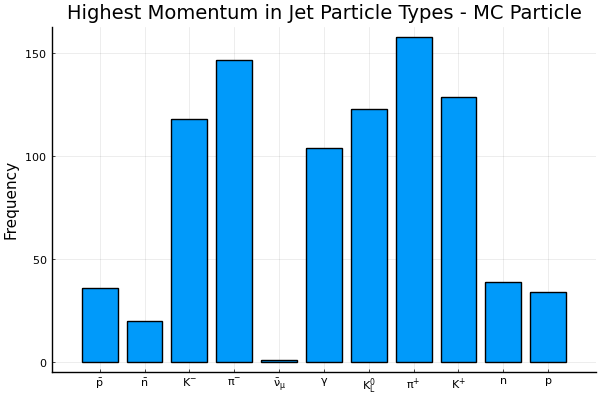

In [55]:
ss_MC_y=ss_MCleadPDG
ss_MC_u=sort(unique(ss_MC_y))
ss_MC_d=Dict([(i,count(x->x==i,ss_MC_y)) for i in ss_MC_u])
ss_MC_vals = [ss_MC_d[i] for i in ss_MC_u]
ss_MC_Names=[]
for key in ss_MC_u
    push!(ss_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(ss_MC_Names, ss_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(ss_MC_u[i])" for i in 1:length(ss_MC_u)]

#StatsPlots.savefig("ss_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Any[L"$\bar{\Xi}^{0}$", L"$\bar{\Xi}^{+}$", L"$\bar{\Sigma}^{-}$", L"$\bar{\Lambda}$", L"$\bar{\Sigma}^{+}$", L"$\bar{p}$", L"$\bar{n}$", L"$K^{-}$", L"$\pi^{-}$", L"$e^{+}$", L"$e^{-}$", L"$\gamma$", L"$K_{L}^{0}$", L"$\pi^{+}$", L"$K_{S}^{0}$", L"$K^{+}$", L"$n$", L"$p$", L"$\Sigma^{-}$", L"$\Lambda$", L"$\Sigma^{+}$", L"$\Xi^{-}$", L"$\Xi^{0}$"]

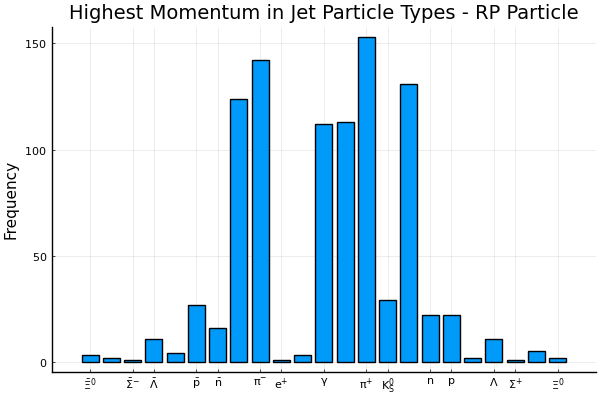

In [60]:
ss_RP_y=ss_PFOleadPDG
ss_RP_u=sort(unique(ss_RP_y))
ss_RP_d=Dict([(i,count(x->x==i,ss_RP_y)) for i in ss_RP_u])
ss_RP_vals = [ss_RP_d[i] for i in ss_RP_u]
ss_RP_Names=[]
for key in ss_RP_u
    push!(ss_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
print(ss_RP_Names)
StatsPlots.bar(ss_RP_Names, ss_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(ss_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(ss_RP_u[i])" for i in 1:length(ss_RP_u)]

#StatsPlots.savefig("ss_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, botton events

In [26]:
fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_bb[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [27]:
bb_MCleadPDG = []
bb_MCleadingParticlePList = []
bb_PFOleadPDG = []
bb_PFOleadingParticlePList = []
bb_kShortInPiPiEventList_MC = []
bb_kShortInPiPiEventList_PFO = []
bb_lambdaInProtonEventList_MC = []
bb_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_bb
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            if iEvent>100
                break
            end
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(bb_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(bb_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(bb_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(bb_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(bb_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(bb_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

["̄{p}", "̄{n}", "K⁻", "π⁻", "̄{ν}ₜₐᵤ", "̄{ν}ₘᵤ", "̄{ν}ₑ", "e⁺", "e⁻", "νₑ", "νₘᵤ", "νₜₐᵤ", "γ", "Kₗ⁰", "π⁺", "K⁺", "n", "p"]

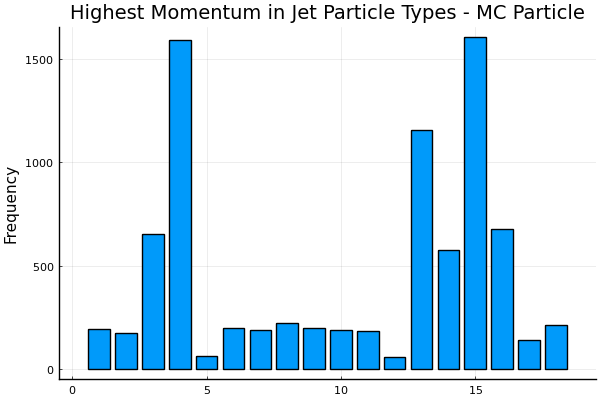

In [28]:
bb_MC_y=bb_MCleadPDG
bb_MC_u=sort(unique(bb_MC_y))
bb_MC_d=Dict([(i,count(x->x==i,bb_MC_y)) for i in bb_MC_u])
bb_MC_vals = [bb_MC_d[i] for i in bb_MC_u]
bb_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in bb_MC_u])
bb_MC_latex = [(bb_MC_Names[convert(Int32, i)]) for i in bb_MC_u]
bb_MC_printed_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{\\tau}", "\\bar{\\nu}_{\\mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{\\mu}", "\\nu_{\\tau}", "\\gamma", "K_{L}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
bb_MC_edit_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{tau}", "\\bar{\\nu}_{mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{mu}", "\\nu_{tau}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
bb_MC_x_axis_names=[to_latex(bb_MC_edit_latex[i]) for i in 1:length(bb_MC_edit_latex)]
print(bb_MC_x_axis_names)
StatsPlots.bar(bb_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(bb_MC_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(bb_MC_u[i])" for i in 1:length(bb_MC_u)]

#StatsPlots.savefig("bb_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

["̄{Ξ}⁰", "̄{Ξ}⁺", "̄{Σ}⁻", "̄{Λ}", "̄{Σ}⁺", "̄{p}", "̄{n}", "K⁻", "π⁻", "e⁺", "e⁻", "γ", "Kₗ⁰", "π⁺", "Kₛ⁰", "K⁺", "n", "p", "Σ⁻", "Λ", "Σ⁺", "Ξ⁻", "Ξ⁰"]

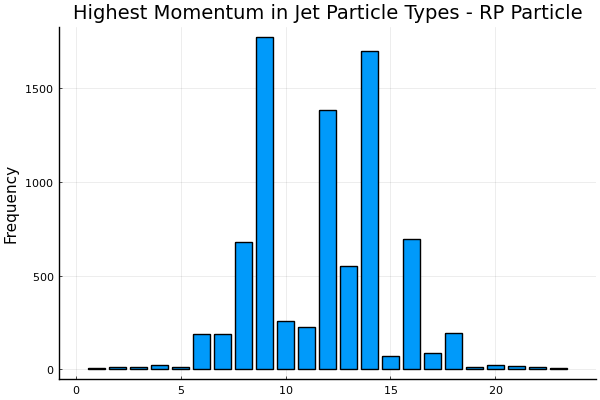

In [29]:
bb_RP_y=bb_PFOleadPDG
bb_RP_u=sort(unique(bb_RP_y))
bb_RP_d=Dict([(i,count(x->x==i,bb_RP_y)) for i in bb_RP_u])
bb_RP_vals = [bb_RP_d[i] for i in bb_RP_u]
bb_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in bb_RP_u])
bb_RP_latex = [(bb_RP_Names[convert(Int32, i)]) for i in bb_RP_u]
bb_RP_printed_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{\\Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\gamma", "K_{L}^{0}", "\\pi^{+}", "K_{S}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
bb_RP_edit_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{\\Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K_{s}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
bb_RP_x_axis_names=[to_latex(bb_RP_edit_latex[i]) for i in 1:length(bb_RP_edit_latex)]
print(bb_RP_x_axis_names)
StatsPlots.bar(bb_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(bb_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(bb_RP_u[i])" for i in 1:length(bb_RP_u)]

#StatsPlots.savefig("bb_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, charm events

In [30]:
fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_cc[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [31]:
cc_MCleadPDG = []
cc_MCleadingParticlePList = []
cc_PFOleadPDG = []
cc_PFOleadingParticlePList = []
cc_kShortInPiPiEventList_MC = []
cc_kShortInPiPiEventList_PFO = []
cc_lambdaInProtonEventList_MC = []
cc_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_cc
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(cc_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(cc_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(cc_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(cc_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(cc_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(cc_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

["̄{p}", "̄{n}", "K⁻", "π⁻", "̄{ν}ₜₐᵤ", "̄{ν}ₘᵤ", "̄{ν}ₑ", "e⁺", "e⁻", "νₑ", "νₘᵤ", "νₜₐᵤ", "γ", "Kₗ⁰", "π⁺", "K⁺", "n", "p"]

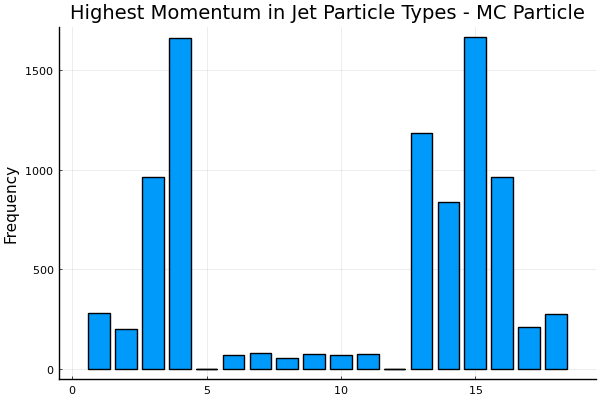

In [32]:
cc_MC_y=cc_MCleadPDG
cc_MC_u=sort(unique(cc_MC_y))
cc_MC_d=Dict([(i,count(x->x==i,cc_MC_y)) for i in cc_MC_u])
cc_MC_vals = [cc_MC_d[i] for i in cc_MC_u]
cc_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in cc_MC_u])
cc_MC_latex = [(cc_MC_Names[convert(Int32, i)]) for i in cc_MC_u]
cc_MC_edit_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{tau}", "\\bar{\\nu}_{mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{mu}", "\\nu_{tau}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
cc_MC_x_axis_names=[to_latex(cc_MC_edit_latex[i]) for i in 1:length(cc_MC_edit_latex)]
print(cc_MC_x_axis_names)
StatsPlots.bar(cc_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(cc_MC_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(cc_MC_u[i])" for i in 1:length(cc_MC_u)]

#StatsPlots.savefig("cc_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

["̄{Ξ}⁰", "̄{Ξ}⁺", "̄{Σ}⁻", "̄{Λ}", "̄{Σ}⁺", "̄{p}", "̄{n}", "K⁻", "π⁻", "e⁺", "e⁻", "γ", "Kₗ⁰", "π⁺", "Kₛ⁰", "K⁺", "n", "p", "Σ⁻", "Λ", "Σ⁺", "Ξ⁻", "Ξ⁰"]

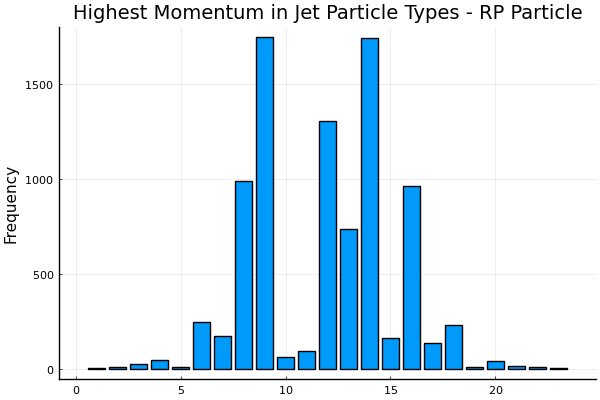

In [33]:
cc_RP_y=cc_PFOleadPDG
cc_RP_u=sort(unique(cc_RP_y))
cc_RP_d=Dict([(i,count(x->x==i,cc_RP_y)) for i in cc_RP_u])
cc_RP_vals = [cc_RP_d[i] for i in cc_RP_u]
cc_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in cc_RP_u])
cc_RP_latex = [(cc_RP_Names[convert(Int32, i)]) for i in cc_RP_u]
cc_RP_edit_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{\\Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K_{s}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
cc_RP_x_axis_names=[to_latex(cc_RP_edit_latex[i]) for i in 1:length(cc_RP_edit_latex)]
print(cc_RP_x_axis_names)
StatsPlots.bar(cc_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(cc_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(cc_RP_u[i])" for i in 1:length(cc_RP_u)]

#StatsPlots.savefig("cc_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, gluon events

In [34]:
fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_gg[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [35]:
gg_MCleadPDG = []
gg_MCleadingParticlePList = []
gg_PFOleadPDG = []
gg_PFOleadingParticlePList = []
gg_kShortInPiPiEventList_MC = []
gg_kShortInPiPiEventList_PFO = []
gg_lambdaInProtonEventList_MC = []
gg_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_gg
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(gg_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(gg_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(gg_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(gg_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(gg_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(gg_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

["̄{p}", "̄{n}", "K⁻", "π⁻", "̄{ν}ₜₐᵤ", "̄{ν}ₘᵤ", "̄{ν}ₑ", "e⁺", "e⁻", "νₑ", "νₘᵤ", "γ", "Kₗ⁰", "π⁺", "K⁺", "n", "p"]

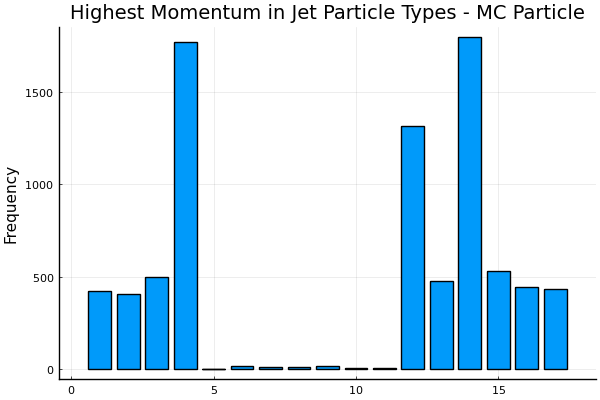

In [36]:
gg_MC_y=gg_MCleadPDG
gg_MC_u=sort(unique(gg_MC_y))
gg_MC_d=Dict([(i,count(x->x==i,gg_MC_y)) for i in gg_MC_u])
gg_MC_vals = [gg_MC_d[i] for i in gg_MC_u]
gg_MC_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in gg_MC_u])
gg_MC_latex = [(gg_MC_Names[convert(Int32, i)]) for i in gg_MC_u]
gg_MC_edit_latex=["\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "\\bar{\\nu}_{tau}", "\\bar{\\nu}_{mu}", "\\bar{\\nu}_{e}", "e^{+}", "e^{-}", "\\nu_{e}", "\\nu_{mu}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K^{+}", "n", "p"]
gg_MC_x_axis_names=[to_latex(gg_MC_edit_latex[i]) for i in 1:length(gg_MC_edit_latex)]
print(gg_MC_x_axis_names)
StatsPlots.bar(gg_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(gg_MC_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(gg_MC_u[i])" for i in 1:length(gg_MC_u)]

#StatsPlots.savefig("gg_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

̄{Ξ}⁺

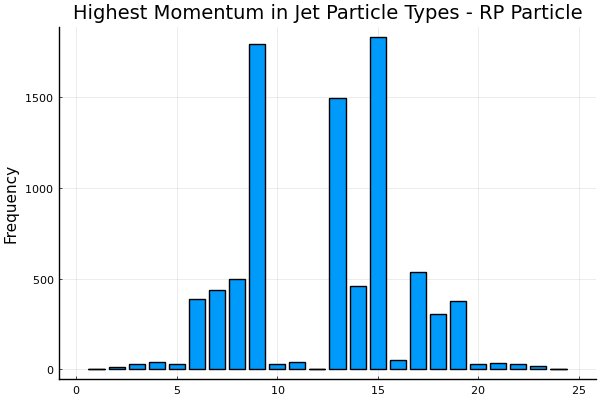

In [37]:
gg_RP_y=gg_PFOleadPDG
gg_RP_u=sort(unique(gg_RP_y))
gg_RP_d=Dict([(i,count(x->x==i,gg_RP_y)) for i in gg_RP_u])
gg_RP_vals = [gg_RP_d[i] for i in gg_RP_u]
gg_RP_Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in gg_RP_u])
gg_RP_latex = [(gg_RP_Names[convert(Int32, i)]) for i in gg_RP_u]
gg_RP_edit_latex=["\\bar{\\Xi}^{0}", "\\bar{\\Xi}^{+}", "\\bar{\\Sigma}^{-}", "\\bar{Lambda}", "\\bar{\\Sigma}^{+}", "\\bar{p}", "\\bar{n}", "K^{-}", "\\pi^{-}", "e^{+}", "e^{-}", "\\nu_{mu}", "\\gamma", "K_{l}^{0}", "\\pi^{+}", "K_{s}^{0}", "K^{+}", "n", "p", "\\Sigma^{-}", "\\Lambda", "\\Sigma^{+}", "\\Xi^{-}", "\\Xi^{0}"]
gg_RP_x_axis_names=[to_latex(gg_RP_edit_latex[i]) for i in 1:length(gg_RP_edit_latex)]
print(gg_RP_x_axis_names[2])
StatsPlots.bar(gg_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#groupedbar(gg_RP_x_axis_names, gg_RP_vals)
#print(gg_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(gg_RP_u[i])" for i in 1:length(gg_RP_u)]

#StatsPlots.savefig("gg_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

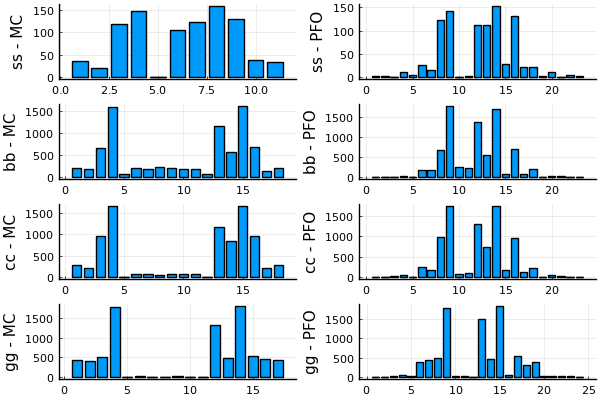

In [38]:
#plot(title="Lead Momentum Particle per Jet - MC Truth and Pandora PFO")
plot(
    StatsPlots.bar(ss_MC_vals, ylabel="ss - MC"),
    StatsPlots.bar(ss_RP_vals, ylabel="ss - PFO"),
    StatsPlots.bar(bb_MC_vals, ylabel="bb - MC"),
    StatsPlots.bar(bb_RP_vals, ylabel="bb - PFO"),
    StatsPlots.bar(cc_MC_vals, ylabel="cc - MC"),
    StatsPlots.bar(cc_RP_vals, ylabel="cc - PFO"),
    StatsPlots.bar(gg_MC_vals, ylabel="gg - MC"),
    StatsPlots.bar(gg_RP_vals, ylabel="gg - PFO"),
    layout=(4,2),
    legend=false,
    )

In [39]:
cm_gg_RP=countmap(gg_RP_y)
print(minimum(gg_RP_y))
total_gg_RP=sum(cm_gg_RP[i] for i in keys(cm_gg_RP))

-3322

8461

In [40]:
cm_ss_MC=countmap(ss_MC_y)
cm_ss_RP=countmap(ss_RP_y)
cm_bb_MC=countmap(bb_MC_y)
cm_bb_RP=countmap(bb_RP_y)
cm_cc_MC=countmap(cc_MC_y)
cm_cc_RP=countmap(cc_RP_y)
cm_gg_MC=countmap(gg_MC_y)
cm_gg_RP=countmap(gg_RP_y)

Dict{Any,Int64} with 24 entries:
  310   => 50
  -11   => 31
  211   => 1830
  11    => 39
  2212  => 377
  3112  => 29
  -2212 => 389
  -211  => 1791
  130   => 458
  321   => 537
  3322  => 2
  -3122 => 41
  22    => 1497
  2112  => 305
  -3312 => 13
  -321  => 499
  3222  => 27
  -2112 => 437
  -3112 => 28
  -3322 => 3
  3122  => 33
  14    => 1
  -3222 => 28
  3312  => 16

In [41]:
MC_all_values=Dict{Int, Array{Float64, 1}}()

MC_sample_list=[cm_ss_MC, cm_bb_MC, cm_cc_MC, cm_gg_MC]
RP_sample_list=[cm_ss_RP, cm_bb_RP, cm_cc_RP, cm_gg_RP]

MC_key_list=Int64[]
for sample in MC_sample_list
    for k in keys(sample)
        push!(MC_key_list, k)
    end
end

MC_key_set=Set(MC_key_list)
#print(key_set)
for key in MC_key_set
    MC_all_values[key]=Int64[]
    for sample in MC_sample_list
        total_value=0
        for sample_key in keys(sample)
            total_value+=get(sample, sample_key,  0)
        end
        push!(MC_all_values[key], get(sample, key, 0)/total_value)
    end
end

MC_grouped_data = hcat([MC_all_values[i] for i in MC_key_set]...)'

18×4 Adjoint{Float64,Array{Float64,2}}:
 0.0         0.00747348  0.000115221  0.000122324
 0.0         0.0268804   0.00633714   0.00159021
 0.173817    0.193467    0.191612     0.219817
 0.0         0.00711186  0.000115221  0.0
 0.0         0.0237464   0.00852633   0.00195719
 0.0374037   0.0257956   0.0320313    0.0533333
 0.039604    0.0235053   0.0322618    0.0514985
 0.161716    0.191779    0.191036     0.216758
 0.135314    0.0696721   0.0966701    0.0583486
 0.141914    0.0816056   0.111073     0.0648318
 0.114411    0.139224    0.136421     0.160734
 0.0429043   0.0172372   0.0243116    0.0544343
 0.129813    0.0789537   0.110727     0.0612844
 0.0220022   0.0213356   0.023505     0.0500306
 0.0         0.022541    0.00898721   0.000978593
 0.0         0.0226615   0.00944809   0.00134557
 0.00110011  0.0239875   0.00841111   0.00183486
 0.0         0.0230231   0.00841111   0.00110092

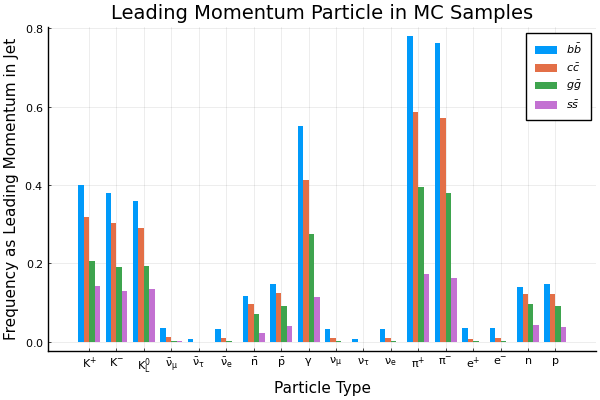

In [42]:
MC_all_values=Dict{Int, Array{Float64, 1}}()

MC_sample_list=[cm_ss_MC, cm_bb_MC, cm_cc_MC, cm_gg_MC]
RP_sample_list=[cm_ss_RP, cm_bb_RP, cm_cc_RP, cm_gg_RP]

MC_key_list=Int64[]
for sample in MC_sample_list
    for k in keys(sample)
        push!(MC_key_list, k)
    end
end

MC_key_set=Set(MC_key_list)
#print(key_set)
for key in MC_key_set
    MC_all_values[key]=Int64[]
    for sample in MC_sample_list
        total_value=0
        for sample_key in keys(sample)
            total_value+=get(sample, sample_key,  0)
        end
        push!(MC_all_values[key], get(sample, key, 0)/total_value)
    end
end

MC_grouped_data = hcat([MC_all_values[i] for i in MC_key_set]...)'
event_type =  repeat([L"$s\bar{s}$", L"$b\bar{b}$", L"$c\bar{c}$", L"$g\bar{g}$"], inner = length(MC_key_set))
MC_key_latex=[]
for key in MC_key_set
    push!(MC_key_latex, latexstring(Particle(key).latex))
end
MC_names=repeat(MC_key_latex, outer=4)
groupedbar(MC_names, MC_grouped_data, group=event_type, 
    xlabel="Particle Type", ylabel="Frequency as Leading Momentum in Jet", title="Leading Momentum Particle in MC Samples", lw=0)

Set([211, 11, -211, 3322, -3122, -3312, -321, 3222, -2112, 14, 310, -11, 2212, 3112, -2212, 130, 321, 22, 2112, -3112, -3322, 3122, -3222, 3312])

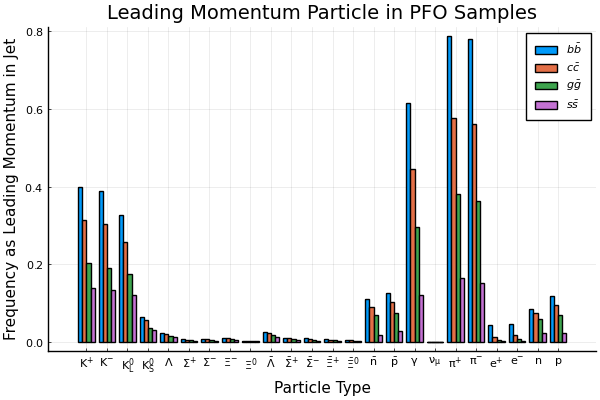

In [43]:
RP_all_values=Dict{Int, Array{Float64, 1}}()

RP_sample_list=[cm_ss_RP, cm_bb_RP, cm_cc_RP, cm_gg_RP]
RP_sample_list=[cm_ss_RP, cm_bb_RP, cm_cc_RP, cm_gg_RP]

RP_key_list=Int64[]
for sample in RP_sample_list
    for k in keys(sample)
        push!(RP_key_list, k)
    end
end

RP_key_set=Set(RP_key_list)
print(RP_key_set)
for key in RP_key_set
    RP_all_values[key]=Int64[]
    for sample in RP_sample_list
        total_value=0
        for sample_key in keys(sample)
            total_value+=get(sample, sample_key,  0)
        end
        push!(RP_all_values[key], get(sample, key, 0)/total_value)
    end
end

RP_grouped_data = hcat([RP_all_values[i] for i in RP_key_set]...)'
event_type =  repeat([L"$s\bar{s}$", L"$b\bar{b}$", L"$c\bar{c}$", L"$g\bar{g}$"], inner = length(RP_key_set))
RP_key_latex=[]
for key in RP_key_set
    push!(RP_key_latex, latexstring(Particle(key).latex))
end
RP_names=repeat(RP_key_latex, outer=4)
groupedbar(RP_names, RP_grouped_data, group=event_type, xlabel="Particle Type", ylabel="Frequency as Leading Momentum in Jet", title="Leading Momentum Particle in PFO Samples")

fix whatever is wrong with the normalization\
xaxis\
look at strange hadrons (k's and lambdas)\
-how many occur in each sample? yup\
-throw out events with none -> whats the efficiency?\
-look at jets: how many do we throw out if we throw out events w/out strange hadron in each jet? yup\
-relative contribution of charged kaons vs other strange hadrons\
-how effective is that?\
z finder on these files

In [44]:
noCutEfficiency=[]
cutEfficiencyNSH=[] #NSH=no strange Hadron; only considers events if they contain k short, k long, or lambda
nStrangeHadronList=[]
#sampleList=[fileList_ss, fileList_bb, fileList_bb, fileList_bb]
strangeHadronPDG = [130, 310, 321]
percentListJetsNSH = []
percentListHasJetLeaderSH = []
percentListBothJetLeaderSH = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for fileList in [fileList_ss]
    eventEfficiencyNoCut = [] #all the event list are to collect proportions per given, they are then averaged
    eventEfficiencyCutNSH = []
    eventJetsNSH = []
    eventListHasJetLeaderSH=[]
    eventListBothJetLeaderSH=[]
    nSignal=0
    nSignalCutNSH=0
    nEventsSH=0
    nJetsNSH=0
    nEventHasJetLeaderSH=0
    nEventBothJetLeaderSH=0
    for FILENAME in fileList
        LCIO.open(FILENAME) do reader
            iEvent=0
            for event in reader
                iEvent+=1
                if iEvent>1000
                    break
                end
                eventIsSignalNoCut=false
                eventIsSignalCutNSH=false
                eventHasSH=false
                rp = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RPparticles = PseudoJet[]
                
                for (iRP, RP) in enumerate(rp)
                    E = getEnergy(RP)
                    p = getMomentum(RP)
                    pj=PseudoJet(p[1], p[2], p[3], E)
                    set_user_index(pj, iRP)
                    push!(RPparticles, pj)
                    mcp = getRelatedToObjects(rel, RP)
                    MCParticle=mcp[1]
                    
                    
                    if abs(getPDG(MCParticle)) in strangeHadronPDG && getGeneratorStatus(MCParticle)==1
                        if eventHasSH==true
                            break
                        end
                        eventHasSH=true
                        nEventsSH+=1
                    end
                end
                
                RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
                RPjets = exclusive_jets(RPcs, 2)
                nRPJet=0
                jetWithoutSH = false
                aJetLeaderIsSH = false
                bothJetLeaderIsSH = false
                for j in RPjets
                    nRPJet+=1
                    nCon=0
                    aConstituentIsSH = false
                    for c in constituents(j)
                        nCon+=1
                        index=FastJet.user_index(c)
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            MCParticle = mcpList[1]
                            if abs(getPDG(MCParticle)) in strangeHadronPDG
                                aConstituentIsSH=true
                                if nRPJet==2 && nCon==leadingParticleIndex(j) && aJetLeaderIsSH==true #only can be this simple for 2 jets
                                    bothJetLeaderIsSH=true
                                end
                                if nCon==leadingParticleIndex(j)
                                    aJetLeaderIsSH=true
                                end
                            end
                        end
                            
                    end
                    if aConstituentIsSH==false
                        jetWithoutSH=true
                    end
                end
                if FastJet.n_particles(RPcs)<0
                    print("你好！")
                end
                if jetWithoutSH==true
                    nJetsNSH+=1
                end
                if aJetLeaderIsSH==true
                    nEventHasJetLeaderSH+=1
                end
                if bothJetLeaderIsSH==true
                    nEventBothJetLeaderSH+=1
                end
            end
            #push!(eventEfficiencyNoCut, nSignal/iEvent)
            push!(eventEfficiencyCutNSH, nEventsSH/iEvent)
            push!(eventJetsNSH, nJetsNSH/iEvent)
            push!(eventListHasJetLeaderSH, nEventHasJetLeaderSH/iEvent)
            push!(eventListBothJetLeaderSH, nEventBothJetLeaderSH/iEvent)
        end
    end
    #push!(noCutEfficiency, mean(eventEfficiencyNoCut))
    push!(cutEfficiencyNSH, mean(eventEfficiencyCutNSH))
    push!(nStrangeHadronList, nEventsSH)
    push!(percentListJetsNSH, mean(eventJetsNSH))
    push!(percentListHasJetLeaderSH, mean(eventListHasJetLeaderSH))
    push!(percentListBothJetLeaderSH, mean(eventListBothJetLeaderSH))
end
                        
                 

In [58]:
percentListHasJetLeaderSH

1-element Array{Any,1}:
 0.584

UndefVarError: UndefVarError: MCParticle not defined